# Roadmap

<img src="all.png" width="400"/>

# 1 - Counting Letters - Attention, Queries, Keys & Values

## Description

### Task Description

Consider a sequence, where each element is a randomly selected letter or null/blank. The task is to count how many times each letter appears in the sequence.

For example:

```python
Input:
['A'], ['B'], [' '], ['B'], ['C']
Output:
[[1], [2], [1]]
```

The output is also a sequence, where each element corresponds to the count of a letter. In the above case, 'A', 'B' and 'C' appear 1, 2 and 1 times respectively.

### Details

#### Input

The actual input to the model consists of sequences of one-hot embeddings, which means the input tensor has shape `(batchsize, max_len, vocab_size + 1)`. 

_A: It is `vocab_size + 1` instead of `vocab_size`, because we need to add a one-hot dimension for the null character as well._

For example, if we set `vocab_size=2`, the possible characters will be 'A', 'B' and ' ' (null). Consider a batch of `batchsize=1` sequence of length `max_len=4`: 

```python
[['A', 'B', ' ', 'A']]
```

The embedding for that will be a tensor of shape (1, 4, 3):

```python
[[[0, 1, 0],
  [0, 0, 1],
  [1, 0, 0],
  [0, 1, 0]]]
```

#### Output / Labels

Similar to the input, the output predictions consists of sequences of one-hot embeddings ie. we represent the counts as one-hot vectors. 

The shape of the predictions is determined by the input parameters. First, the length of the prediction corresponds to the `vocab_size`. Next the dimension of each step in a predicted sequence corresponds to `max_len + 1`.

Hence the output/labels tensor should have a shape of `(batchsize, vocab_size, max_len + 1)`.

_A: It's `max_len + 1` because the minimum count is 0 and the maximum count is `max_len`. So there are `max_len + 1` possible answers._

If we use the input above as an example, the plain prediction is `[[2, 1]]`, while the embedding is a tensor of shape (1, 2, 5):

```python
[[[0, 0, 1, 0, 0],
  [0, 1, 0, 0, 0]]]
```

#### Model

**Attention ie. Queries, Keys, Values**

The essence of attention lies in the idea of **Queries**, **Keys** and **Values**. 

Suppose we have a supermarket catalogue of product names and respective prices and I want to calculate the average price of drinks. The **Query** is 'drinks', the **Keys** are all the product names and the **Values** are the respective prices. We focus our attention on **Values** (prices) of **Keys** (product names) that align most with our **Query** ('drinks').

_A: Here's what the training data might look like:_

```python
[
  input: [[Pepsi, 0.69$], [Twixies, 0.34$], [Coke, 0.32$]], # product names, prices
  label: [1.01$] # average price of drinks
], 
[
  input: [[Snickers, 0.03$], [San Periggglo, 0.21$], [Herring, 0.60$]], # product names, prices
  label: [0.21$] # average price of drinks
], 
```

_The model will, based on the training data,  learn to represent in the latent space 
which products are drinks. We didn't explicitly tell it what are drinks, and it doesn't explicitly produce that
as the output, but the things it will be looking for in the latent space align most closely to what we call drinks
in the real world._

See how the **Query** and **Keys** have to be the same type? You can see if two words align ('drinks' vs 'water') but you can't align a word with a number, or temperature with prices. Likewise, in the attention mechanism, the **Query** and **Keys** have to have the same dimensions.

In scaled dot-product attention, we calculate alignment using the dot product. Intuitively, we see that if the **Query** and the **Key** are in the same direction, their dot product will be large and positive. If the **Query** and the **Key** are orthogonal, the dot product will be zero. Finally, if the **Query** and the **Key** are in opposite directions, their dot product will be large and negative.

We then allocate more attention on **Values** whose **Keys** align to the **Query**. To do this, we simply multiply the softmax of the dot product by the **Values**. This gives us a weighted sum of the **Values**, where aligned **Keys** contribute more to this weighted sum.

_A: Through training we _learn_ to give more attention to the keys that _give_ the correct weighted values_

Have a look at the `attention` method from the `AttentionModel` class in the script.

Following the Transformer architecture by Vaswani et al. (2017), the weighted sum is added back to the **Query** via residual connections (Figure 1 and Section 3.1). The sum of **Query** and weighted sum is then layer-normalized and passed to the next step.

Why do we use the sum of the weighted sum and the original **Query** instead of just the weighted sum?

One way of understanding it is because the **Query** may contain important information that cannot be found in the **Values**. To take a simple example, suppose I have two **Key**/**Value** pairs, `[1 0]:[0 1]` and `[0 1]:[0 1]` ie. two different **Keys** `[1 0]` and `[0 1]` with both having the same **Values** `[0 1]` and `[0 1]`. 

If my **Query** is `[1 0]`, then my weighted sum will be `[0 1]` ie. the **Value** of **Key** `[1 0]`. 

On the other hand, if my **Query** is `[0 1]`, my weighted sum will still be `[0 1]` ie. the **Value** of **Key** `[0 1]`. 

If we pass the weighted sum to the next layer, we lose information about the **Query**. The next layer has no way of telling whether my **Query** was `[1 0]` or `[0 1]`. If we instead pass the sum of the weighted sum and the original **Query**, we retain the information since the vector that we pass on can be either `[0 2]` or `[1 1]`.

Now, we need to think about what are our **Queries**, **Keys** and **Values**. 

**Queries**

We want the first step of the output sequence to count the number of 'A's and the second step to count the number of 'B's and so on. Why not have one **Query** vector per output step? The first **Query** vector can check for 'A's and the second **Query** vector can check for 'B's and so on. _A: This is what we're going to do._

In that case, our **Queries** tensor will be of shape `(batch_size, vocab_size, hidden)`. `vocab_size` is the second dimension since we have one **Query** vector for each element in our vocabulary. `hidden` will be the dimension of each **Query** vector.

We will let the model learn the **Queries** tensor, by initializing it as a trainable `nn.Parameter`:

```python3
self.query = nn.Parameter(torch.zeros((1, self.vocab_size, self.hidden)))
```

*Notice the first dimension for `decoder_query` in the code above is 1. This is because we will use `torch.repeat` to change it to `batch_size` at runtime.*

**Keys and Values**

Following the above input/output examples, our input is of shape (1, 4, 3) ie. a length-4 sequence of 3-dim vectors, where each vector is a representation of a character. To create **Key**/**Value** pairs for each character, we can simply pass the input into two regular fully-connected feedforward networks - one for generating a **Key** for each character and one for generating a **Value**.

In fact, we just need one regular fully-connected feedforward network, to generate a **Key**/**Value** for each character ie. the vector acts as both **Key** and **Value**.

Like the **Queries** tensor, we set the output dimension for both networks to `hidden` where `hidden=64` by default. We then end up with a tensor of shape (1, 4, 64). Each 64-dim vector in the tensor acts as both **Key** and **Value** for each character. 

```python3
self.key_val_dense = nn.Linear(self.vocab_size + 1, self.hidden)
```

**Decoding and Softmax**

All that's left is then to compute the scaled dot-product attention, using the **Queries** tensor and the **Keys**/**Values** tensor.

We then pass that to a regular feedforward network to get logits of `self.max_len + 1` dimensions and we just `torch.argmax` these logits to get the predictions.

```python3
decoding, self.attention_weights = self.attention(
    self.query.repeat(key_val.shape[0], 1, 1),
    key_val,
    key_val)
self.final_dense = nn.Linear(self.hidden, self.max_len + 1)
logits = self.final_dense(decoding)
predictions = logits.argmax(dim=2)
```

That's mainly it for the short and simplified demo of attention for the counting task!

Here's a summary figure for the algorithm used in this Task!

<div>
<img src="1_counting-letters/images/task_1.png" alt="task_1" width="800px" height="whatever" style="display: block;">
</div>

### Notes

If you look at the attention weights printed out when testing the model, you will notice that the same characters are assigned the same weights. That does not seem correct when you consider, for example, language processing - the same words in different positions should be accorded different weights.

In the case of this toy experiment, the order of the input sequence does not matter, since we are just counting characters. But if the order is important, as with the output sequence here, we can use positional encodings, as used by Vaswani et al. (2017) (see Figure 1 and Section 3.5 of the paper).The idea here is to modify the input and output embeddings to help the model differentiate between steps. Vaswani et al. does this by simply adding sine and cosine functions to the embeddings. 

In our case, while position is irrelevant for the input sequence, it is important for the output sequence ie. the meanings of the elements in the output sequence are represented almost entirely by their position eg. we know that the first element in the output counts the number of 'A's by the fact that it is the first element. So we actually do use positional encodings to differentiate between the output steps. Specifically, the **Queries** vector that is initialized as a trainable `nn.Parameter` is our positional encoding for the output. In this case, we allow the model to learn its own positional encoding.

<img src="1_counting-letters/1.png" width="400"/>

## Implementation

In [5]:
import seaborn
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F

In [6]:
from all_tasks import *

In [7]:
task = CountingLettersTask()

samples, labels = task.next_batch(batchsize=1)
print("\nInput: \n{}".format(task.prettify(samples)))


Input: 
[[['B']
  ['C']
  ['A']
  ['C']
  ['B']
  ['C']
  [' ']
  ['A']
  ['B']
  ['A']]]


In [8]:
class AttentionModel(nn.Module):
    def __init__(self, max_len=10, vocab_size=3, hidden=64):
        super().__init__()

        self.max_len = max_len
        self.vocab_size = vocab_size
        self.hidden = hidden

        self.query = nn.Parameter(torch.zeros((1, self.vocab_size, self.hidden), requires_grad=True))
        self.key_val_dense = nn.Linear(self.vocab_size + 1, self.hidden)
        
        self.norm = nn.LayerNorm(self.hidden)
        self.linear = nn.Linear(self.hidden, self.max_len + 1) # final output

    def forward(self, x): # x: (1, 10, 4)
        key_val = self.key_val_dense(x) # (1, 10, 64)
        query = self.query.repeat(key_val.shape[0], 1, 1) # (1, 3, 64)

        attention, self.attention_weights = scaled_dot_product_attention(  # (1, 3, 64), (1, 3, 10)
            query,
            key_val,
            key_val)
        
        add_and_norm = self.norm(attention + query) # (1, 3, 64)        
        linear = self.linear(add_and_norm) # (1, 3, 11)
        
        return linear, self.attention_weights

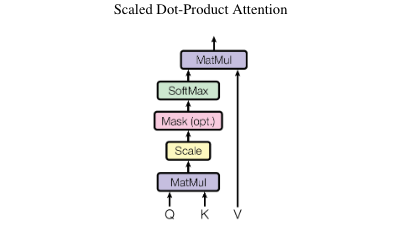

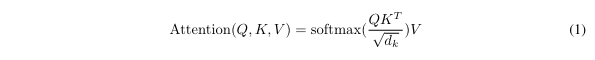

In [9]:
def scaled_dot_product_attention(query, key, value, mask=False):
    d_k = query.shape[2] # 64
    scaling_factor = torch.tensor(np.sqrt(d_k)) # 8
    dot_product = torch.bmm(
        query, key.transpose(1, 2) # (1, 3, 64) x (1, 64, 10) = (1, 3, 10)
    ) 
    scaled_dot_product = dot_product / scaling_factor
    
    # Explained in Task 5
    if mask:
        mask = torch.triu(torch.ones_like(scaled_dot_product), diagonal=1).bool()
        scaled_dot_product = scaled_dot_product.masked_fill_(mask, -np.inf)

    attention_weights = F.softmax(scaled_dot_product, dim=2)
    weighted_sum = torch.bmm(attention_weights, value) # (1, 3, 10) x (1, 10, 64) = (1, 3, 64)

    return weighted_sum, attention_weights    


Input: 
[[['B']
  ['C']
  ['A']
  ['C']
  ['B']
  ['C']
  [' ']
  ['A']
  ['B']
  ['A']]]

Prediction: 
[[3 3 3]]

Encoder-Decoder Attention: 


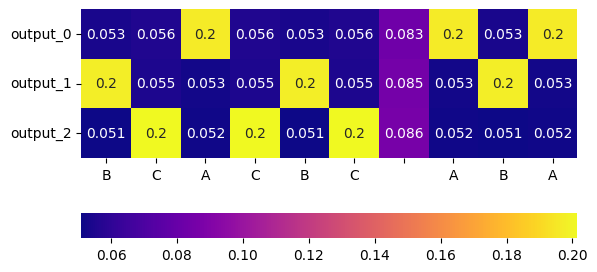

In [10]:
savepath='1_counting-letters/models'

print("\nInput: \n{}".format(task.prettify(samples)))

model = AttentionModel()
model.load_state_dict(torch.load(savepath + '/ckpt.pt'))

model.eval()
with torch.set_grad_enabled(False):
    predictions, attention = model(torch.Tensor(samples))

predictions = predictions.detach().numpy()
predictions = predictions.argmax(axis=2)
print("\nPrediction: \n{}".format(predictions))

attention = attention.detach().numpy()
print("\nEncoder-Decoder Attention: ")

fig, ax = plt.subplots()
seaborn.heatmap(
    attention[0],
    yticklabels=["output_0", "output_1", "output_2"],
    xticklabels=task.prettify(samples).reshape(-1),
    ax=ax,
    cmap='plasma',
    cbar=True,
    cbar_kws={"orientation": "horizontal"},
    annot=True,
)
ax.set_aspect('equal')
for tick in ax.get_yticklabels():
    tick.set_rotation(0)
plt.show()

# 2 - Difference - Self-attention

## Description

### Preface

In Task 1, we look at how attention can be used to count letters in a sequence. In that task, the output steps were generally independent of each other. Compare this to language translation, where the N-th word in the output translation is generally considered to be dependent on the previously translated N-1 words, as well as the input sentence.

In this task, we try to demonstrate two things:

1. Show that inter-token dependence in the output can actually be reframed as input dependence ie. explicitly modelling inter-token dependence in the output seems to be unnecessary _A: i.e. show that we can achieve our goal without self-attention first_
2. Despite that, show that self-attention can be used to explicitly model inter-token dependence _A: i.e. show that self-attention improves performance_

This Task is pretty similar to Task 1, with the exception of an additional step in the output that computes the absolute difference between the first and second steps. In that sense, this additional step is dependent on the first and second steps in the output sequence.

### Description

Consider a sequence, where each element is a randomly selected letter or null/blank. The task has two parts: 

1. Count how many times each letter appears in the sequence
2. Calculate the absolute difference between the first two counts

For example:

```python3
Input:
['A'], ['B'], [' '], ['B'], ['C']
Output:
[[1], [2], [1], [1]]
```

The output is also a sequence, where each element corresponds to the count of a letter and the last element corresponds to the difference between the first two elements. In the above case, 'A', 'B' and 'C' appear 1, 2 and 1 times respectively, while counts for 'A' and 'B' differ by 1.

As per Task 1, I implement the Scaled Dot-Product Attention (described in Section 3.2.1 of [Vaswani *et al.* (2017)](https://arxiv.org/abs/1706.03762)) for this task. I also demonstrate a simple case of self-attention in this task.

There are two main models that can be trained with the script, with and without the `--self_att` flag, denoting whether to use self-attention.

#### Without `self_att`

_A: The model withouth self_att would be equivalent to the one in Task 1. The only difference is the training data. This part illustrates that the model still manages to learn. The next part shows that learning is improved if we include self_att._ 

Here is a sample output from the script without `self_att` ie. similar to Task 1 but with an additional output step.

```python3
Input: 
[[['A']
  [' ']
  ['A']
  ['A']
  ['B']
  ['C']
  [' ']
  ['C']
  ['B']
  [' ']]]

Prediction: 
[[3 2 2 1]]

Encoder-Decoder Attention: 
Output step 0 attended mainly to Input steps: [0 2 3]
[0.186, 0.085, 0.186, 0.186, 0.031, 0.062, 0.085, 0.062, 0.031, 0.085]
Output step 1 attended mainly to Input steps: [4 8]
[0.037, 0.105, 0.037, 0.037, 0.204, 0.083, 0.105, 0.083, 0.204, 0.105]
Output step 2 attended mainly to Input steps: [5 7]
[0.049, 0.08, 0.049, 0.049, 0.051, 0.256, 0.08, 0.256, 0.051, 0.08]
Output step 3 attended mainly to Input steps: [0 2 3]
[0.134, 0.082, 0.134, 0.134, 0.123, 0.053, 0.082, 0.053, 0.123, 0.082]
```

As per Task 1, we see the output steps attending to their respective letters in the input sequence eg. Output Step 0 attending to the positions of 'A's at Input Steps 0, 2 and 3. 

More interestingly, we see that Output Step 3 actually attends to positions of both 'A' and 'B'. Looking at the attention of Output Step 3, the maximum attention weight of 0.134 is assigned to Input Steps 0, 2 and 3, which hold the 'A's. But attention weights of 0.123 are also assigned to Input Steps 4 and 8, which hold 'B's.


<div>
<img src="2_difference/images/enc_attention_noself.png" alt="encoder attention heatmap no self" width="400px" height="whatever" style="display: block;">
</div>

In other words, Output Step 3 can be modeled as being dependent on Output Steps 0 and 1. But it can also be modeled as simply being dependent on the inputs of Output Steps 0 and 1. With this simple example, we can see that although there is superficial inter-token dependence in the output, this can be reframed as input dependence. 

_i.e. we don't need to use self-attention to accomplish this task, we can just attend to the inputs, as in Task 1_

However, we do concede that explicitly modeling inter-token dependence in the output can have its advantages, such as leading to simpler and more interpretable models, which brings us to the model with `self_att`.

### With `self_att`

With `self_att` we allow the output to attend to and modify itself, based on itself. The script now prints  the self-attention weights ie. how much attention each output step gives to every step in the output sequence (including itself).

```python3
Input: 
[[['B']
  ['B']
  ['B']
  ['A']
  [' ']
  ['A']
  ['C']
  ['A']
  ['B']
  ['B']]]

Prediction: 
[[3 5 1 2]]

Encoder-Decoder Attention: 
Output step 0 attended mainly to Input steps: [3 5 7]
[0.053, 0.053, 0.053, 0.196, 0.08, 0.196, 0.065, 0.196, 0.053, 0.053]
Output step 1 attended mainly to Input steps: [0 1 2 8 9]
[0.152, 0.152, 0.152, 0.042, 0.061, 0.042, 0.05, 0.042, 0.152, 0.152]
Output step 2 attended mainly to Input steps: [6]
[0.068, 0.068, 0.068, 0.07, 0.157, 0.07, 0.292, 0.07, 0.068, 0.068]
Output step 3 attended mainly to Input steps: [4]
[0.097, 0.097, 0.097, 0.098, 0.114, 0.098, 0.105, 0.098, 0.097, 0.097]

Self-Attention: 
Attention of Output step 0:
[1.0, 0.0, 0.0, 0.0]
Attention of Output step 1:
[0.0, 0.989, 0.0, 0.011]
Attention of Output step 2:
[0.001, 0.007, 0.99, 0.002]
Attention of Output step 3:
[0.003, 0.627, 0.002, 0.368]
```

First, with `self_att`, the Encoder-Decoder Attention weights for Output Step 3 is now much more evenly divided across all the input steps. Since we now allow the modelling of inter-token dependence in the output via self-attention, Output Step 3 can gather more information later from Output Steps 0 and 1.

<div>
<img src="2_difference/images/enc_attention_self.png" alt="encoder attention heatmap no self" width="400px" height="whatever" style="display: block;">
</div>

*Attention heatmap of output steps on the input sequence.*

In the Self-Attention weights, notice that Output Steps 0, 1 and 2 are generally narcissistic and pay nearly 100% attention to themselves. This is because they are largely independent, just like the output in Task 1.

However, Output Step 3 pays far less attention to itself (37%) and instead pays a lot of attention to Output Step 1 (63%). 


_A: Question: Shouldn't it pay all of its attention to output_0 and ouput_1. Not just ouput_1. And not at all to itself?
Possible intuition: In the first, encoder step, output_3 is "counting" all A and
B's. In the self-attention step, it's paying attentiont to 
that count, i.e. itself, and the count of all the B's. In 
other words, (A+B) - B. This can be seen in the example image, where the attention
for C and '' are different, than the ones for A and B._


<div>
<img src="2_difference/images/self_attention_self.png" alt="encoder attention heatmap no self" width="200px" height="whatever" style="display: block;">
</div>

*Self-attention heatmap of output steps.*

By allowing the output sequence to self-attend, we enable the modelling of inter-token dependencies. 

_A: Inter-token: In the first part, we were only looking at the input sequence. So 
each 'row' of the matrix was only looking at the input data. Now, we have an 
extra step where we allow them to look at each others encodings._

### Input

This is exactly like the inputs for Task 1.

### Output

This is similar to the outputs for Task 1, with the exception of an additional step that computes the absolute difference between the first two steps.

Hence the output tensor is of shape `(batchsize, vocab_size + 1, max_len + 1)`.

### Model

Here we will focus on explaining the self-attention part of the model. For the general attention mechanism, refer to Task 1.

**Self-Attention**

This is an extract of the code that is run when `self_att` is enabled.

```python3
decoding, self_attention_weights = self.attention(
	query=decoding,
	key=decoding,
	value=decoding,
)
```

With the exception of the addition above, the model is exactly the same as in Task 1.

Actually, to be more accurate, the self-attention here could be described as attending to the **previous** `decoding`.

Here is one way to think about it. Let's explicitly term pre-self-attention `decoding` as `decoding_pre` and post-self-attention `decoding` as `decoding_post`. We can rewrite the above code snippet as: 

```python3
decoding_post, self_attention_weights = self.attention(
	query=decoding_pre,
	key=decoding_pre,
	value=decoding_pre,
)
```

`decoding_pre` combines the original **Query** with a weighted sum of the inputs (see Task 1). Step 0 in `decoding_pre` focuses on the 'A's in the input sequence, Step 1 in `decoding_pre` focuses on the 'B's in the input sequence and so on. The last step, which should be computing the difference of Output Steps 0 and 1, may just look at the entire input sequence instead of focusing on particular steps.

Then with self-attention, the last step in `decoding_post` can focus on Steps 0 and 1 in `decoding_pre`, to get the difference between the two steps. The other steps in `decoding_post` can focus on themselves in `decoding_pre` ie. copy their own previous values, since they already have enough information to generate the correct output.

This is shown clearly in the printed self-attention weights when you test the model trained with `self_att`:

```python3
Self-Attention: 
Attention of Output step 0:
[1.0, 0.0, 0.0, 0.0]
Attention of Output step 1:
[0.0, 1.0, 0.0, 0.0]
Attention of Output step 2:
[0.009, 0.006, 0.965, 0.021]
Attention of Output step 3:
[0.696, 0.06, 0.038, 0.205]
```

Output Step 3 distributes attention to other steps,  while the other steps all focus on themselves.

<img src="2_difference/2.png" width="400"/>

## Implementation

In [11]:
class SelfAttentionModel(AttentionModel):
    def __init__(self, self_att=False):
        super().__init__()
        
        self.self_att = self_att
        # Extra output for difference
        self.query = nn.Parameter(torch.zeros((1, self.vocab_size + 1, self.hidden), requires_grad=True))

    def forward(self, x):
        key_val = self.key_val_dense(x)
        query = self.query.repeat(key_val.shape[0], 1, 1) # (1, 3, 64)

        attention, enc_attention_weights = scaled_dot_product_attention(  # (1, 3, 64), (1, 3, 10)
            query,
            key_val,
            key_val)
        
        add_and_norm = self.norm(attention + query) # (1, 3, 64)
                
        # Begin: Difference from AttentionModel
        decoding_pre = add_and_norm
        # This can be thought of N = 2 layers of attention, i.e. the Nx in the
        # diagram
        if self.self_att:
            attention, self_attention_weights = scaled_dot_product_attention(  # (1, 3, 64), (1, 3, 10)
                decoding_pre,
                decoding_pre,
                decoding_pre)
            
            add_and_norm = self.norm(attention + query) # (1, 3, 64)

            decoding = add_and_norm # decoding_post
        else:
            self_attention_weights = None
            decoding = decoding_pre
        # End: Difference from AttentionModel
        
        linear = self.linear(decoding)
        
        return linear, enc_attention_weights, self_attention_weights

In [12]:
task = TaskDifference()
samples, labels = task.next_batch(batchsize=1)

In [13]:
# (batchsize, max_len, vocab_size + 1)
samples.shape

(1, 10, 4)

In [14]:
samples[0]

array([[0., 0., 1., 0.],
       [0., 0., 0., 1.],
       [0., 1., 0., 0.],
       [0., 0., 0., 1.],
       [0., 0., 1., 0.],
       [0., 0., 0., 1.],
       [1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 1., 0.],
       [0., 1., 0., 0.]])

In [15]:
# (batchsize, vocab_size + 1, max_len + 1)
labels.shape

(1, 4, 11)

In [16]:
labels[0]

array([[0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])

In [17]:
print("\nInput: \n{}".format(task.prettify(samples)))


Input: 
[[['B']
  ['C']
  ['A']
  ['C']
  ['B']
  ['C']
  [' ']
  ['A']
  ['B']
  ['A']]]


In [18]:
savepath='2_difference/models'


Input: 
[[['B']
  ['C']
  ['A']
  ['C']
  ['B']
  ['C']
  [' ']
  ['A']
  ['B']
  ['A']]]

Prediction: 
[[1 1 0 0]]

Encoder-Decoder Attention: 
Output step 0 attended mainly to Input steps: [2 7]
[0.044, 0.065, 0.195, 0.065, 0.044, 0.065, 0.088, 0.195, 0.044, 0.195]
Output step 1 attended mainly to Input steps: [8]
[0.191, 0.064, 0.051, 0.064, 0.191, 0.064, 0.082, 0.051, 0.191, 0.051]
Output step 2 attended mainly to Input steps: [1 3 5]
[0.05, 0.214, 0.045, 0.214, 0.05, 0.214, 0.075, 0.045, 0.05, 0.045]
Output step 3 attended mainly to Input steps: [0 4 8]
[0.125, 0.069, 0.118, 0.069, 0.125, 0.069, 0.065, 0.118, 0.125, 0.118]


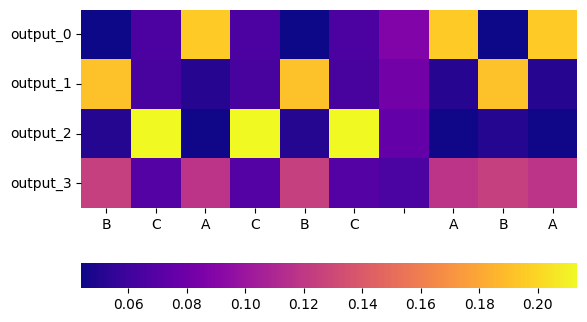

In [19]:
print("\nInput: \n{}".format(task.prettify(samples)))

self_att=False
    
model = SelfAttentionModel(self_att=self_att)

model.load_state_dict(torch.load(savepath + '/ckpt.pt'))
model.eval()
with torch.set_grad_enabled(False):
    predictions, attention, self_attention = model(torch.Tensor(samples))
predictions = predictions.detach().numpy()
predictions = predictions.argmax(axis=2)
attention = attention.detach().numpy()

print("\nPrediction: \n{}".format(predictions))
print("\nEncoder-Decoder Attention: ")
for i, output_step in enumerate(attention[0]):
    print("Output step {} attended mainly to Input steps: {}".format(
        i, np.where(output_step >= np.max(output_step))[0]))
    print([float("{:.3f}".format(step)) for step in output_step])

fig, ax = plt.subplots()
seaborn.heatmap(
    attention[0],
    yticklabels=["output_0", "output_1", "output_2", "output_3"],
    xticklabels=task.prettify(samples).reshape(-1),
    ax=ax,
    cmap='plasma',
    cbar=True,
    cbar_kws={"orientation": "horizontal"})
ax.set_aspect('equal')
for tick in ax.get_yticklabels():
    tick.set_rotation(0)
plt.show()


Input: 
[[['B']
  ['C']
  ['A']
  ['C']
  ['B']
  ['C']
  [' ']
  ['A']
  ['B']
  ['A']]]

Prediction: 
[[3 3 3 0]]

Encoder-Decoder Attention: 
Output step 0 attended mainly to Input steps: [2 7]
[0.044, 0.065, 0.195, 0.065, 0.044, 0.065, 0.088, 0.195, 0.044, 0.195]
Output step 1 attended mainly to Input steps: [8]
[0.191, 0.064, 0.051, 0.064, 0.191, 0.064, 0.082, 0.051, 0.191, 0.051]
Output step 2 attended mainly to Input steps: [1 3 5]
[0.05, 0.214, 0.045, 0.214, 0.05, 0.214, 0.075, 0.045, 0.05, 0.045]
Output step 3 attended mainly to Input steps: [0 4 8]
[0.125, 0.069, 0.118, 0.069, 0.125, 0.069, 0.065, 0.118, 0.125, 0.118]


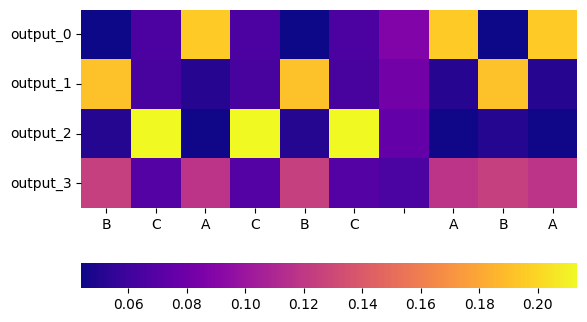


Self-Attention: 
Attention of Output step 0:
[1.0, 0.0, 0.0, 0.0]
Attention of Output step 1:
[0.0, 1.0, 0.0, 0.0]
Attention of Output step 2:
[0.0, 0.0, 1.0, 0.0]
Attention of Output step 3:
[0.033, 0.038, 0.0, 0.928]


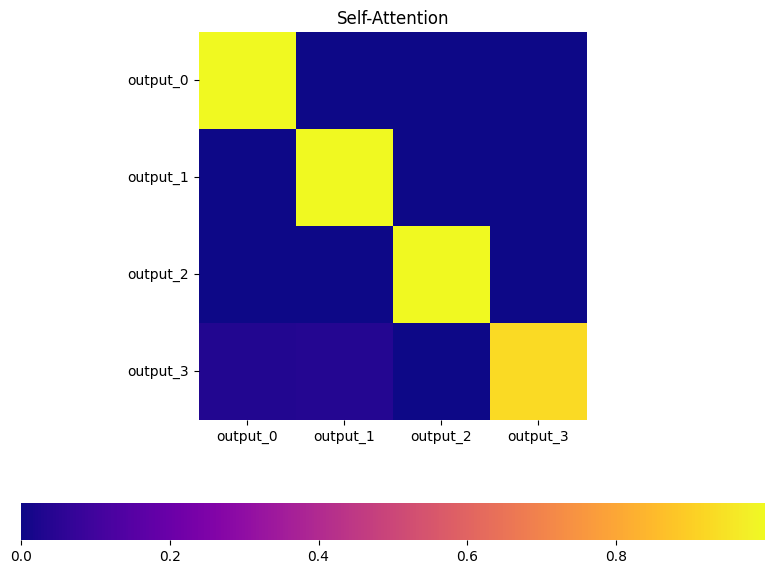

In [20]:
print("\nInput: \n{}".format(task.prettify(samples)))

self_att=True
    
model = SelfAttentionModel(self_att=self_att)

model.load_state_dict(torch.load(savepath + '/ckpt.pt'))
model.eval()
with torch.set_grad_enabled(False):
    predictions, attention, self_attention = model(torch.Tensor(samples))
predictions = predictions.detach().numpy()
predictions = predictions.argmax(axis=2)
attention = attention.detach().numpy()

print("\nPrediction: \n{}".format(predictions))
print("\nEncoder-Decoder Attention: ")
for i, output_step in enumerate(attention[0]):
    print("Output step {} attended mainly to Input steps: {}".format(
        i, np.where(output_step >= np.max(output_step))[0]))
    print([float("{:.3f}".format(step)) for step in output_step])

fig, ax = plt.subplots()
seaborn.heatmap(
    attention[0],
    yticklabels=["output_0", "output_1", "output_2", "output_3"],
    xticklabels=task.prettify(samples).reshape(-1),
    ax=ax,
    cmap='plasma',
    cbar=True,
    cbar_kws={"orientation": "horizontal"})
ax.set_aspect('equal')
for tick in ax.get_yticklabels():
    tick.set_rotation(0)
plt.show()


self_attention = self_attention.detach().numpy()
print("\nSelf-Attention: ")
for i, output_step in enumerate(self_attention[0]):
    print("Attention of Output step {}:".format(i))
    print([float("{:.3f}".format(step)) for step in output_step])

fig2, ax2 = plt.subplots()
seaborn.heatmap(
    self_attention[0],
    yticklabels=["output_0", "output_1", "output_2", "output_3"],
    xticklabels=["output_0", "output_1", "output_2", "output_3"],
    ax=ax2,
    cmap='plasma',
    cbar=True,
    cbar_kws={"orientation": "horizontal"})
ax2.set_aspect('equal')
ax2.set_title("Self-Attention")
curr_fig_size = fig2.get_size_inches()
fig2.set_size_inches(curr_fig_size[0]*1.5, curr_fig_size[1]*1.5)
for tick in ax2.get_yticklabels():
    tick.set_rotation(0)
plt.show()

# 3 - Signal - Positional Encoding & Encoding Layers

## Description

### Preface

At the end of Task 1, we mentioned that the order of the input sequence does not matter, since we are just counting letters (see Task 1 Notes section).

Here, we consider a task where the order of the input sequence is paramount. Specifically, the first step of the input sequence acts as a signal to tell the model which letter to count.

_A: step = position in the array_

The output is a sequence of a single step, which represents the count of the letter specified by the signal.

For instance, if the first step (signal) is 'A', the model should output the counts of 'A's, not including the signal. 

The model has to learn to recognize the signal purely by its position, since no other information is available ie. the signal for 'A' is identical to a regular 'A' in the sequence. This is similar to language processing, where the identical words can have vastly different meanings in different positions/contexts.

### Description

Consider a sequence, where each element is a randomly selected letter. We call the first element the *signal*. 

For example ('B' is the signal here):

```python3
Input:
['B'], ['B'], ['A'], ['B'], ['C']
Output:
[[2]]
```

The output is a sequence of one step, corresponding to the count of the letter specified by the signal (first input step).

In the above case, the first input step is 'B', which means that we have to count the number of 'B's in the following sequence. The output is hence 2, since there are 2 'B's in the sequence (not counting the signal).

In particular, all the 'B's, including the signal, are represented with the same vector when passed to the model. This means that the model must learn that the meaning of a 'B' changes, depending on whether it is the first letter or not.

Since the task here is slightly more complicated, I implement the entire encoder layer, with self-attention (but not multi-head) (see left half of Figure 1 and Section 3.1 in [Vaswani *et al.* (2017)](https://arxiv.org/abs/1706.03762)). For decoding I just implement a simple scaled dot-product attention as per Task 1. There is no self-attention for the decoding.

#### Without `pos_enc`

Without positional encodings, the model has no way to differentiate whether an input step is a signal or a regular step. As a result, the model simply does not learn well without positional encodings.

Sample of losses when training without `--pos_enc`:

```python3
Iteration 500 - Loss 1.3295859098434448
Iteration 1000 - Loss 1.227324366569519
Iteration 1500 - Loss 1.0068984031677246
Iteration 2000 - Loss 0.9906516075134277
```

The losses generally stop decreasing after reaching about 1. The decrease in loss can be attributed to the model learning the range of possible output values and possibly choosing to focus on counting a fixed letter, which makes its predictions more reliable than random. However, it clearly does not learn well.

#### With `pos_enc`

With positional encodings, the model is able to encode the positions of the input sequence into the input embeddings, which allows the model to recognize which is the first step in the sequence.

Sample of losses when training with `--pos_enc`:

```python3
Iteration 500 - Loss 1.3017479181289673
Iteration 1000 - Loss 0.115713931620121
Iteration 1500 - Loss 0.05086364597082138
Iteration 2000 - Loss 0.014654741622507572
```

With positional encodings, the model learns way better. By checking the attention weights in the Encoder-Decoder Attention layer, we can also see that the decoder pays extra attention to the first step of the sequence, which gives the signal.

Sample output from testing the model trained with `--pos_enc`:

```
Input: 
[[['B']
  ['A']
  ['A']
  ['B']
  ['B']
  ['C']
  ['B']
  ['B']
  ['C']
  ['B']
  ['A']]]

Prediction: 
[[5]]

Encoder-Decoder Attention: 
Output step 0 attended mainly to Input steps: [0]
[0.237, 0.086, 0.087, 0.058, 0.058, 0.106, 0.058, 0.058, 0.108, 0.058, 0.086]

L2-Norm of Input Positional Encoding:
[0.827, 0.153, 0.151, 0.152, 0.156, 0.156, 0.157, 0.153, 0.155, 0.151, 0.155]
```

In the above output, despite Input Steps 0, 3, 4, 6, 7, 9 all being 'B's, the decoder pays extra attention (24%) to Input Step 0.

<div>
<img src="3_signal/images/attention.png" alt="attention heatmap" width="400px" height="whatever" style="display: block;">
</div>

*Attention heatmap of output steps on input sequence.*

We can also check the L2-Norm for each vector in the positional encoding, where each vector represents the positional encoding for each step in the input sequence.

<div>
<img src="3_signal/images/positional_encodings.png" alt="positional_encodings" width="400px" height="whatever" style="display: block;">
</div>

*L2-norm of positional encodings for each input step.*

Here the L2-Norm of the positional vector is far larger for the first step (0.816) than for the rest of the input sequence (~0.18). This makes perfect sense, since the first step has to be modified to encode its status as the signal. On the other hand, the model should leave the rest of the sequence untouched since a 'B' in the second step should be no different from a 'B' in the last step. As such, the positional vectors for the other steps have a much smaller L2-norm and modifies the steps less. More on this in the Details.

*This experiment started out as an attempt to see if we can explicitly change the attention weights assigned to different letters by changing the signal ie. if the signal is 'B', the attention assigned to 'B's should be higher. However, this only seems to occur infrequently. Perhaps via self-attention, the sequence encodes the relevant information into the first step (signal) so the decoder simply focuses on the first step. Or it could be just spread out across all the steps so the decoder does not explicitly focus on the relevant letters in the input sequence. Maybe more on this in the future.*

#### Adjusting `--num_enc_layers`

_A: You can think of Task 2 as having --num_enc_layers=2_

Using the script, we can also adjust the number of encoder layers, where each layer comprises self-attention, followed by a regular feed-forward network (see Figure 1 and Section 3.1 in Vaswani et al. (2017)).

The number of encoder layers allow each step in the sequence to incorporate and encode information from other steps. Figure 4 in Vaswani et al. (2017) shows a good example with the following sentence:

```python3
The Law will never be perfect, but its application should be just - this is what we are missing, in my opinion.
```

By inspecting the self-attention weights for the word `its`, Vaswani et al. (2017) found heavier attentions for the words `Law` and `application`, which are very contextually relevant.

In our case, the use of encoder layers allow the input sequence to modify itself based on its own signal. In particular, the decoder is restricted to a single scaled dot-product attention layer, which means that the encoder has to find a good representation for the sequence, so that the decoder can quickly retrieve the relevant information via a single attention layer.

In general, we find that with increasing `--num_enc_layers`, the decoder's attention on the first step (signal) tends to decrease, in the Encoder-Decoder Attention layer.

The previous sample output was trained with `--num_enc_layers=1`, where the attention weight on the signal was 32%.

Sample output from testing the model trained with `--pos_enc` and `--num_enc_layers=6`:

```python3
Input: 
[[['C']
  ['B']
  ['B']
  ['B']
  ['A']
  ['C']
  ['C']
  ['C']
  ['B']
  ['C']
  ['A']]]

Prediction: 
[[4]]

Encoder-Decoder Attention: 
Output step 0 attended mainly to Input steps: [7]
[0.08, 0.076, 0.076, 0.076, 0.092, 0.108, 0.108, 0.108, 0.076, 0.108, 0.092]

L2-Norm of Input Positional Encoding:
[0.884, 0.115, 0.119, 0.114, 0.116, 0.12, 0.116, 0.122, 0.118, 0.119, 0.12]
```

In contrast to the previous output from `--num_enc_layers=1`, the attention weight on the signal here is far smaller at only 8%.

Very hypothetically, it could be that the use of more encoder layers allows the encoding to spread out the information across all the steps, making the decoder less reliant on a single step.

### Details

#### Input

This is similar to the inputs for Task 1, with two exceptions:

- An additional first step that serves as the signal, which makes the second dimension `max_len + 1`
- No null character so the last dimension is simply `vocab_size`

The input tensor has shape `(batchsize, max_len + 1, vocab_size)`.

#### Output

The output just consists of sequences of length 1, representing the count of the signal-specified letter, which ranges from 0 to `max_len`.

The output tensor is of shape `(batchsize, 1, max_len + 1)`.

#### Model

**Positional Encoding**

We touched on this briefly at the end of Task 1 in the Notes section, where we discussed how the **Queries** tensor is also a form of positional encoding for the output.

First, consider the embedding of the input:

```python3
self.base_enc_layer = nn.Linear(self.vocab_size, self.hidden)
```

Since this is a simple position-wise feedforward network, an input vector of 'A' will always output the same encoding vector of `hidden` dimension, regardless of the vector's position. (We use 'A' here as an example but the same logic applies to every other character.)

Likewise, if we pass this straight to the Encoder-Decoder Attention layer, the same attention weights will be assigned to every vector that represents 'A'. In that sense, the decoder has no way of differentiating a signal 'A' from a regular 'A'.

Will self-attention help?

Nope. Just as in the Encoder-Decoder Attention layer, the same attention weights will be assigned to every vector that represents 'A', no matter how many times you apply self-attention to the encodings.

Instead, we simply add positional encoding.

```python3
self.input_pos_enc = nn.Parameter(torch.zeros((1, self.max_len + 1, self.hidden)))

if self.pos_enc:
    # Add positional encodings
    encoding += self.input_pos_enc
```

Here, we allow the model to learn the positional encoding by initializing it as a trainable `nn.Parameter`, just as with the **Queries** tensor from Task 1. Then, we just add it to the encodings.

Notice that the shape of the positional encoding is `(1, max_len + 1, hidden)` ie. for each step in a length `max_len + 1` sequence, there is a vector of `hidden` dimension that represents information about the position. When we add this to the encoding, the addition is broadcasted to each sequence in the batch.

With this, an 'A' in one input step is different from an 'A' in another input step, since the positional vector at each input step is different. Furthermore, in this task, we know that the first step is significantly different as the signal, whereas the positions of the other steps are not very important. In fact, it is best if the positional encoding only changes the first step and leaves the rest of the sequence untouched, since position does not matter for the rest of the sequence. We see this clearly in the L2-norms of the positional vectors in the sample outputs from earlier (reproduced below), which are larger for the first step and much smaller for the rest of the steps.

From model trained with `--pos_enc` and `num_enc_layers=1`:

```
L2-Norm of Input Positional Encoding:
[0.816, 0.181, 0.183, 0.185, 0.186, 0.18, 0.185, 0.183, 0.185, 0.183, 0.178]
```

From model trained with `--pos_enc` and `num_enc_layers=6`:

```
L2-Norm of Input Positional Encoding:
[0.884, 0.115, 0.119, 0.114, 0.116, 0.12, 0.116, 0.122, 0.118, 0.119, 0.12]
```


<img src="3_signal/3.png" width="400"/>

## Implementation

In [21]:
task = SignalTask()
samples, labels = task.next_batch()

In [22]:
task.prettify(samples[0])

array([[['A'],
        ['A'],
        ['A'],
        ['C'],
        ['B'],
        ['B'],
        ['C'],
        ['C'],
        ['A'],
        ['B'],
        ['A']]], dtype='<U1')

In [23]:
labels[0].argmax()

4

In [24]:
# (batchsize, max_len + 1, vocab_size)
samples.shape

(1, 11, 3)

In [25]:
samples[0]

array([[1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [0., 0., 1.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 0., 1.],
       [0., 0., 1.],
       [1., 0., 0.],
       [0., 1., 0.],
       [1., 0., 0.]])

In [26]:
# (batchsize, 1, max_len + 1)
labels.shape

(1, 1, 11)

In [27]:
labels[0]

array([[0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.]])

In [28]:
class PosEncLayersAttentionModel(SelfAttentionModel):
    def __init__(self, pos_enc=True, num_enc_layers=1):
        super().__init__()

        self.query = None # we will have many queries, keys and values now
        self.key_val_dense = None 

        self.pos_enc = pos_enc
        self.num_enc_layers = num_enc_layers
        
        self.input_embedding = nn.Linear(self.vocab_size, self.hidden) # can be
        # thought of as the query from previous exercise
        self.input_pos_enc = nn.Parameter(torch.zeros((1, self.max_len + 1, self.hidden)))
        
        # `enc_` as in Encoder, the left side of the diagram       
        # Creates an array of num_enc_layers nn.Sequential objects. Each is part
        # of its own layer, and does not share weights with the
        self.enc_feed_forwad = nn.ModuleList([
            nn.Sequential(
                nn.Linear(self.hidden, self.hidden * 2), # (11, 128)
                nn.ReLU(),
                nn.Linear(self.hidden * 2, self.hidden) # (11, 64)
            )
            for i in range(self.num_enc_layers)
        ])
        self.enc_layer_norm = nn.ModuleList([
            nn.LayerNorm(self.hidden)
            for i in range(self.num_enc_layers)])

        self.output_embedding = nn.Linear(1, self.hidden)

    def forward(self, x): # x: (11, 3)
        encoding = self.input_embedding(x) # (11, 64)
        
        if self.pos_enc:
            # Add positional encodings
            encoding += self.input_pos_enc # (11, 64)

        #  After each iteration of the loop, encoding remains a tensor of shape 
        # (100, 11, 64). Our output becomes the input for the next layer.
        for i in range(self.num_enc_layers):
            attention, _ = scaled_dot_product_attention(
                encoding, 
                encoding, 
                encoding
            )   
            # This was implemented differently than the diagram. Each layer 
            # should have its own norm also in this part. 
            add_and_norm = self.norm(attention + encoding)

            # We have #num_enc_layers "separate networks", each trained for
            # a specific layer.
            feed_forward = self.enc_feed_forwad[i](add_and_norm) # (11, 128) -> (11, 64)
            add_and_norm = self.enc_layer_norm[i](feed_forward + add_and_norm)

            encoding = add_and_norm # (11, 64)

        # Right side
        # We know that we expect the output to be 1 token, 
        # so we can hardcode it here.
        # This can be done with nn.Parameter
        ones = torch.ones(x.shape[0], 1, 1)
        output_embedding = self.output_embedding(ones) # (1, 64)
        
        attention, attention_weights = scaled_dot_product_attention( # (1, 64), (1, 11)
            output_embedding, 
            encoding,  # (11, 64)
            encoding
        )
        add_and_norm = self.norm(attention + output_embedding)
            
        linear = self.linear(add_and_norm) # (1, 11)

        return linear, attention_weights, self.input_pos_enc

## Run

In [29]:
savepath='3_signal/models/'

###  Without positional encoding, 1 encoding layer


Input: 
[[['A']
  ['A']
  ['A']
  ['C']
  ['B']
  ['B']
  ['C']
  ['C']
  ['A']
  ['B']
  ['A']]]

Prediction: 
[[4]]

Encoder-Decoder Attention: 
Output step 0 attended mainly to Input steps: [10]
[0.149, 0.149, 0.149, 0.026, 0.058, 0.058, 0.026, 0.026, 0.149, 0.058, 0.149]


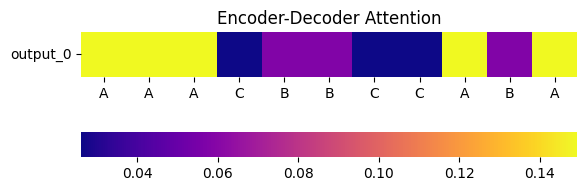

In [30]:
model = PosEncLayersAttentionModel(pos_enc=False,
                                   num_enc_layers=1)
model.load_state_dict(torch.load(savepath + '/ckpt-without_enc.pt'))

print("\nInput: \n{}".format(task.prettify(samples)))
model.eval()
with torch.set_grad_enabled(False):
    predictions, attention, input_pos_enc = model(torch.Tensor(samples))
predictions = predictions.detach().numpy()
predictions = predictions.argmax(axis=2)
attention = attention.detach().numpy()

print("\nPrediction: \n{}".format(predictions))
print("\nEncoder-Decoder Attention: ")
for i, output_step in enumerate(attention[0]):
    print("Output step {} attended mainly to Input steps: {}".format(
        i, np.where(output_step >= np.max(output_step))[0]))
    print([float("{:.3f}".format(step)) for step in output_step])

fig, ax = plt.subplots()
seaborn.heatmap(
    attention[0],
    yticklabels=["output_0"],
    xticklabels=task.prettify(samples).reshape(-1),
    ax=ax,
    cmap='plasma',
    cbar=True,
    cbar_kws={"orientation": "horizontal"})
ax.set_aspect('equal')
ax.set_title("Encoder-Decoder Attention")
for tick in ax.get_yticklabels():
    tick.set_rotation(0)
plt.show()

###  With positional encoding, 1 encoding layer


Input: 
[[['A']
  ['A']
  ['A']
  ['C']
  ['B']
  ['B']
  ['C']
  ['C']
  ['A']
  ['B']
  ['A']]]

Prediction: 
[[4]]

Encoder-Decoder Attention: 
Output step 0 attended mainly to Input steps: [0]
[0.972, 0.003, 0.003, 0.003, 0.003, 0.003, 0.003, 0.003, 0.003, 0.003, 0.003]


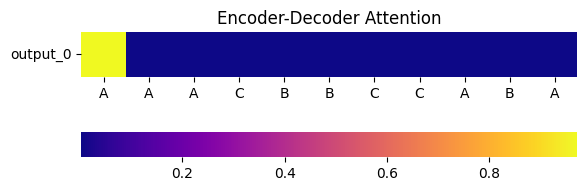


L2-Norm of Input Positional Encoding:
[1.235, 0.535, 0.523, 0.539, 0.526, 0.509, 0.542, 0.543, 0.541, 0.516, 0.546]


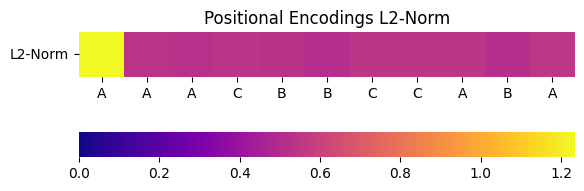

In [31]:
model = PosEncLayersAttentionModel(pos_enc=True,
                       num_enc_layers=1)
model.load_state_dict(torch.load(savepath + '/ckpt-with_enc.pt'))

print("\nInput: \n{}".format(task.prettify(samples)))
model.eval()
with torch.set_grad_enabled(False):
    predictions, attention, input_pos_enc = model(torch.Tensor(samples))
predictions = predictions.detach().numpy()
predictions = predictions.argmax(axis=2)
attention = attention.detach().numpy()

print("\nPrediction: \n{}".format(predictions))
print("\nEncoder-Decoder Attention: ")
for i, output_step in enumerate(attention[0]):
    print("Output step {} attended mainly to Input steps: {}".format(
        i, np.where(output_step >= np.max(output_step))[0]))
    print([float("{:.3f}".format(step)) for step in output_step])

fig, ax = plt.subplots()
seaborn.heatmap(
    attention[0],
    yticklabels=["output_0"],
    xticklabels=task.prettify(samples).reshape(-1),
    ax=ax,
    cmap='plasma',
    cbar=True,
    cbar_kws={"orientation": "horizontal"})
ax.set_aspect('equal')
ax.set_title("Encoder-Decoder Attention")
for tick in ax.get_yticklabels():
    tick.set_rotation(0)
plt.show()


input_pos_enc = input_pos_enc.detach().numpy()
print("\nL2-Norm of Input Positional Encoding:")
print([
    float("{:.3f}".format(step))
    for step in np.linalg.norm(input_pos_enc, ord=2, axis=2)[0]])

fig2, ax2 = plt.subplots()
seaborn.heatmap(
    [np.linalg.norm(input_pos_enc, ord=2, axis=2)[0]],
    vmin=0.,
    # vmax=.5,
    yticklabels=["L2-Norm"],
    xticklabels=task.prettify(samples).reshape(-1),
    ax=ax2,
    cmap='plasma',
    cbar=True,
    cbar_kws={"orientation": "horizontal"})
ax2.set_aspect('equal')
ax2.set_title("Positional Encodings L2-Norm")
for tick in ax2.get_yticklabels():
    tick.set_rotation(0)
plt.show()

###  With positional encoding, 6 encoding layers


Input: 
[[['A']
  ['A']
  ['A']
  ['C']
  ['B']
  ['B']
  ['C']
  ['C']
  ['A']
  ['B']
  ['A']]]

Prediction: 
[[4]]

Encoder-Decoder Attention: 
Output step 0 attended mainly to Input steps: [0]
[0.844, 0.014, 0.014, 0.016, 0.018, 0.018, 0.016, 0.016, 0.014, 0.018, 0.014]


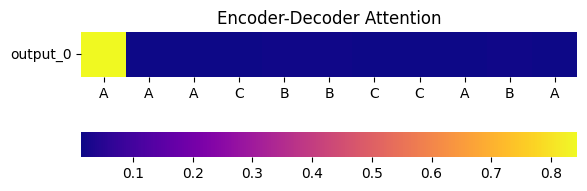


L2-Norm of Input Positional Encoding:
[1.401, 0.3, 0.301, 0.317, 0.304, 0.316, 0.308, 0.3, 0.306, 0.291, 0.309]


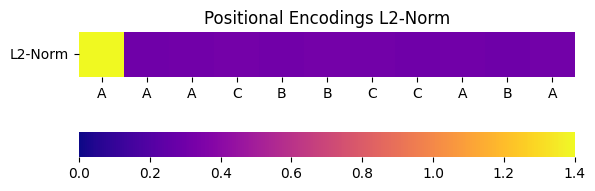

In [32]:
model = PosEncLayersAttentionModel(
    pos_enc=True,
    num_enc_layers=6
    )
model.load_state_dict(torch.load(savepath + '/ckpt-6_enc_layers.pt'))

print("\nInput: \n{}".format(task.prettify(samples)))
model.eval()
with torch.set_grad_enabled(False):
    predictions, attention, input_pos_enc = model(torch.Tensor(samples))
predictions = predictions.detach().numpy()
predictions = predictions.argmax(axis=2)
attention = attention.detach().numpy()

print("\nPrediction: \n{}".format(predictions))
# TODO: Shouldn't we have 6 attention layers?
print("\nEncoder-Decoder Attention: ")
for i, output_step in enumerate(attention[0]):
    print("Output step {} attended mainly to Input steps: {}".format(
        i, np.where(output_step >= np.max(output_step))[0]))
    print([float("{:.3f}".format(step)) for step in output_step])

fig, ax = plt.subplots()
seaborn.heatmap(
    attention[0],
    yticklabels=["output_0"],
    xticklabels=task.prettify(samples).reshape(-1),
    ax=ax,
    cmap='plasma',
    cbar=True,
    cbar_kws={"orientation": "horizontal"})
ax.set_aspect('equal')
ax.set_title("Encoder-Decoder Attention")
for tick in ax.get_yticklabels():
    tick.set_rotation(0)
plt.show()


input_pos_enc = input_pos_enc.detach().numpy()
print("\nL2-Norm of Input Positional Encoding:")
print([
    float("{:.3f}".format(step))
    for step in np.linalg.norm(input_pos_enc, ord=2, axis=2)[0]])

fig2, ax2 = plt.subplots()
seaborn.heatmap(
    [np.linalg.norm(input_pos_enc, ord=2, axis=2)[0]],
    vmin=0.,
    # vmax=.5,
    yticklabels=["L2-Norm"],
    xticklabels=task.prettify(samples).reshape(-1),
    ax=ax2,
    cmap='plasma',
    cbar=True,
    cbar_kws={"orientation": "horizontal"})
ax2.set_aspect('equal')
ax2.set_title("Positional Encodings L2-Norm")
for tick in ax2.get_yticklabels():
    tick.set_rotation(0)
plt.show()

# 4 - Signal 2 - Multi-Headed Attention

## Description

### Preface

The output of Task 3 consists of sequences of length 1, which is somewhat trivial. Task 4 is an extension to Task 3, where there are three signals instead of one, which leads to an output sequence of length 3, where each step corresponds to one signal.

With the increased complexity of this task, we introduce multihead-attention, which will demonstrate a far larger capacity compared to attention with a single head.

### Description

Consider a sequence, where each element is a randomly selected letter. We call the first three elements the *signals*. 

For example ('C', 'B', 'B' are the signals here):

```
Input:
['C'], ['B'], ['B'], ['B'], ['A'], ['B'], ['C']
Output:
[[1], [2], [2]]
```

The output is a sequence of three steps, corresponding to the count of the letter specified by each signal (first three input steps).

In the above case, the first input step is 'C', which means that we have to count the number of 'C's in the following sequence. The output is hence 1, since there is 1 'C' in the sequence (not counting the signal).

Likewise, for the second and third signals. Also, note that signals can be repeated, like the repeated 'B' signals in the example above.

I implement the entire encoder layer, with multihead-self-attention (see left half of Figure 1 and Section 3.1 in [Vaswani *et al.* (2017)](https://arxiv.org/abs/1706.03762)). For decoding I just implement a single multihead-attention layer. There is no self-attention for the decoding. In all attention layers, the number of heads used is `--heads=4` by default. The `--pos_enc` flag is enabled by default as well.

There are two main models that can be trained with the script, with and without `--multihead`. More precisely, since `--multihead=True` by default here, we can pass `--multihead=False` when running the script to disable `--multihead`.

More on multihead-attention in the Details section.

#### With `--multihead=False`

Without multihead-attention, the model here is the same as the model used in Task 3. 

Sample of losses when training with `--multihead=False`:

```
Iteration 1000 - Loss 1.430114507675171
Iteration 2000 - Loss 1.1829146146774292
Iteration 3000 - Loss 1.075669288635254
Iteration 4000 - Loss 0.8190537095069885
```

The model seems to have insufficient capacity to learn well.

#### With `--multihead=True`

With multihead-attention, despite using the same number of attention layers, the model has a much larger capacity and learns much faster.

Sample of losses when training with `--multihead=True`:

```
Iteration 1000 - Loss 0.6175369024276733
Iteration 2000 - Loss 0.04598541930317879
Iteration 3000 - Loss 0.026927191764116287
Iteration 4000 - Loss 0.0017624727915972471
```

Sample output from testing the model trained with `--multihead=True`:

```python3
Input:
[[['B']
  ['C']
  ['C']
  ['C']
  ['B']
  ['A']
  ['A']
  ['B']
  ['A']
  ['C']
  ['C']
  ['C']
  ['A']]]

Prediction:
[[2 4 4]]

Encoder-Decoder Attention:
Attention of Output step 0 on Input steps
    Head #0
    [0.09, 0.091, 0.076, 0.065, 0.065, 0.088, 0.089, 0.065, 0.088, 0.065, 0.064, 0.064, 0.088]
    Head #1
    [0.459, 0.088, 0.095, 0.034, 0.052, 0.032, 0.029, 0.051, 0.03, 0.033, 0.033, 0.034, 0.03]
    Head #2
    [0.128, 0.003, 0.044, 0.003, 0.244, 0.084, 0.077, 0.239, 0.084, 0.003, 0.003, 0.003, 0.084]
    Head #3
    [0.023, 0.002, 0.062, 0.064, 0.029, 0.156, 0.149, 0.029, 0.15, 0.062, 0.062, 0.065, 0.149]
Attention of Output step 1 on Input steps
    Head #0
    [0.097, 0.189, 0.018, 0.076, 0.085, 0.057, 0.057, 0.085, 0.057, 0.074, 0.075, 0.074, 0.056]
    Head #1
    [0.023, 0.757, 0.001, 0.039, 0.016, 0.009, 0.01, 0.016, 0.01, 0.037, 0.038, 0.036, 0.009]
    Head #2
    [0.107, 0.037, 0.078, 0.035, 0.13, 0.095, 0.093, 0.129, 0.095, 0.035, 0.035, 0.035, 0.095]
    Head #3
    [0.055, 0.024, 0.076, 0.077, 0.06, 0.106, 0.104, 0.059, 0.105, 0.077, 0.076, 0.078, 0.104]
Attention of Output step 2 on Input steps
    Head #0
    [0.006, 0.001, 0.695, 0.009, 0.004, 0.063, 0.063, 0.004, 0.061, 0.01, 0.009, 0.009, 0.066]
    Head #1
    [0.023, 0.0, 0.782, 0.006, 0.018, 0.035, 0.031, 0.018, 0.033, 0.007, 0.006, 0.007, 0.034]
    Head #2
    [0.117, 0.0, 0.023, 0.0, 0.316, 0.061, 0.053, 0.305, 0.061, 0.0, 0.0, 0.0, 0.061]
    Head #3
    [0.008, 0.0, 0.042, 0.044, 0.012, 0.198, 0.184, 0.011, 0.187, 0.042, 0.042, 0.046, 0.184]

L2-Norm of Input Positional Encoding:
[1.47, 1.564, 1.911, 0.295, 0.287, 0.292, 0.299, 0.286, 0.291, 0.293, 0.289, 0.291, 0.29]
```

The output shows three sets of attention, one for each step of the output sequence. For each step, there are also four subsets of attention, each corresponding to a head. Each head shares the same weights, so we can look across the output steps to see what each head tries to focus on.

For example, Head #1 seems to be focusing on the relevant input signal for each output step (query), since the Head #1 attention is 45.9% for Output Step 0 on Input Step 0 (Signal 1), 75.7% for Output Step 1 on Input Step 1 (Signal 2) and 78.2% for Output Step 2 on Input Step 2 (Signal 3).

Also, Head #3 seems to be primarily fixated on the 'A's in the sequence, irregardless of which output step serves as the query.

Of course, these trends will differ from training run to training run and are actually rather inconsistent between training runs.

Again, we can check the L2-Norm for each vector in the positional encoding and as per the trend in Task 3, we also see here that the L2-Norms of the positional vectors for the signals are far larger than for the rest of the sequence.

#### Input

This is similar to the inputs for Task 1, with two exceptions:

- Additional first three step that serve as the signals, which makes the second dimension `max_len + 3`
- No null character so the last dimension is simply `vocab_size`

The input tensor has shape `(batchsize, max_len + 3, vocab_size)`.

#### Output

The output just consists of sequences of length 3, representing the count of each signal-specified letter, which ranges from 0 to `max_len`.

The output tensor is of shape `(batchsize, 3, max_len + 1)`.

#### Model

**Multihead-Attention**

In regular attention, we simply compare alignment of the **Queries** with the **Keys** to get a softmax-ed set of weights, which we use to calculate a weighted sum of the **Values**.


In multihead-attention, we first multiply the **Queries**, **Keys** and **Values** by respective weight tensors. Suppose the original tensors are all of shape `batchsize, length, hidden` and all consist of vectors of `hidden=64` dimensions and we want to implement multihead-attention with 4 heads. We then construct `4*3=12` weight tensors ie. 4 each for **Queries**, **Keys** and **Values**. Each weight tensor will be of shape `(hidden, hidden / 4)`, which means the outputs will consist of `64/4=16`-dimensional vectors. 

_A: If total size of our latent space is 64, then thik of the attention heads as sub-dividing that latent space during training into 4 latent-sub-spaces. It is then likely that they will learn different concepts in those sub-spaces._

After multiplying the **Queries**, **Keys** and **Values** by their respective weight tensors (4 each), we will have 4 sets of **Queries**, **Keys** and **Values** tensors. The new tensors each consist of 16-dimensional vectors, as compared to the 64-dimensional vectors in the original tensors. 

We then proceed to do regular scaled dot-product attention with each of the 4 sets of **Queries**, **Keys** and **Values** tensors. We will then end up with 4 outputs, each of shape `(batchsize, length, 16)`. We concatenate these outputs along the last dimension, which gives us a large tensor of shape `(batchsize, length, 16*4=64)`. Notice that we get back `hidden` as the last dimension ie. the shape is also `(batchsize, length, hidden)`.

Finally we construct a output weight tensor of shape `(hidden, hidden)` and multiply the concatenated output with this weight tensor to obtain our final multihead output of shape `(batchsize, length, hidden)`.

The primary advantage of using multihead-attention is the additional complexity/capacity due to two main factors.

1. The additional linear mappings from multiplying by the learned weight tensors (notice the weight tensors are similar to feedforward networks but without bias and activation)

_A: In the current implementation this is not true. We indeed use a linear feedforward layer, because this produced better training results_

2. In each multihead-attention layer, instead of just a single attention, we get to perform and aggregate over `h` variations of attention

On a last note, while Vaswani et al. (2017) and this script defines `h` as a factor of `hidden`, it is actually possible to use any `h` and each weight tensor can be of shape `(hidden, d)` where `d` can be any size. The only consideration is that the output weight tensor has to be of shape `(h * d, hidden)` so that the final multihead output is still of shape `(batchsize, length, hidden)`.

<img src="4_signal2/4.png" width="400"/>

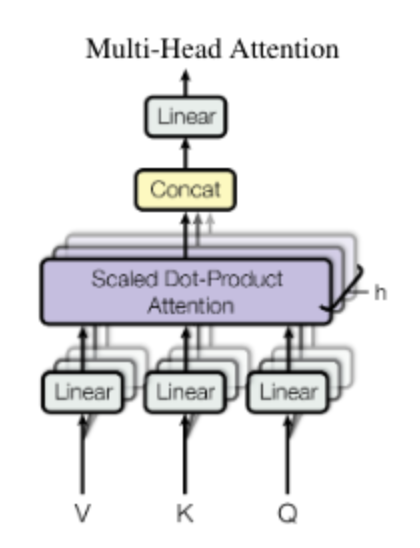

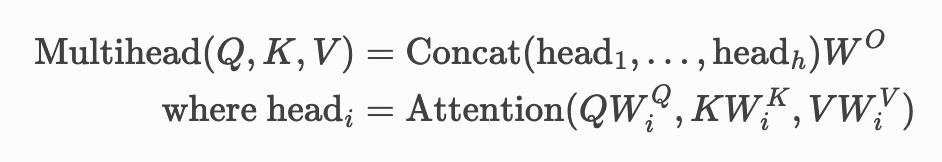

## Implementation

In [33]:
task = TaskThreeSignals()
samples, labels = task.next_batch()

In [34]:
# (batchsize, max_len + 3, vocab_size)
samples.shape

(1, 13, 3)

In [35]:
samples[0]

array([[0., 0., 1.],
       [0., 1., 0.],
       [0., 0., 1.],
       [1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.],
       [0., 1., 0.],
       [1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.]])

In [36]:
# (batchsize, 3, max_len + 1)
labels.shape

(1, 3, 11)

In [37]:
labels[0]

array([[0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.]])

In [38]:
task.prettify(samples[0])

array([[['C'],
        ['B'],
        ['C'],
        ['A'],
        ['B'],
        ['C'],
        ['B'],
        ['A'],
        ['B'],
        ['C'],
        ['A'],
        ['A'],
        ['A']]], dtype='<U1')

In [39]:
np.argmax(labels[0], axis=1)

array([2, 3, 2])

In [40]:
# We implement use only multi-headed attention here, without an option to switch
# back to regular attention. 
# The task folder provides an implmentation, where you can switch it
# on and off and see the effect on the training. 
class MultiHeadAttentionModel(PosEncLayersAttentionModel):
    def __init__(self, num_heads=4, **kwargs):
        super().__init__(**kwargs)
        
        # Now it's + 3
        self.input_pos_enc = nn.Parameter(torch.zeros((1, self.max_len + 3, self.hidden)))

        self.heads = num_heads
        self.enc_mult_att = nn.ModuleList([
            MultiHeadAttention(self.heads, self.hidden)
            for i in range(self.num_enc_layers)
        ])
        # We add individual attention norms for each layer now
        self.enc_layer_att_norm = nn.ModuleList([
            nn.LayerNorm(self.hidden)
            for i in range(self.num_enc_layers)])        

        self.output_embedding = None # we will use a parameter instead
        self.output_embedding_param = nn.Parameter(torch.zeros((1, 3, self.hidden)))

        # We implement only N=1 layers of the decoder
        self.enc_dec_mult_att = MultiHeadAttention(self.heads, self.hidden)
        self.enc_dec_att_norm = nn.LayerNorm(self.hidden)
        self.dec_feed_forward = nn.Sequential(
            nn.Linear(self.hidden, self.hidden * 2), # (11, 128)
            nn.ReLU(),
            nn.Linear(self.hidden * 2, self.hidden) # (11, 64)
        )
        self.dec_layer_norm = nn.LayerNorm(self.hidden)

    def forward(self, x): # (13, 3)
        # Left side
        input_embedding = self.input_embedding(x) # (13, 64)

        if self.pos_enc:
            encoding = input_embedding + self.input_pos_enc

        for i in range(self.num_enc_layers):
            # We now use enc_mult_att instead of scaled_dot_product_attention
            multi_headed_attention, _ = self.enc_mult_att[i](
                encoding, 
                encoding, 
                encoding
            )            
            add_and_norm = self.enc_layer_att_norm[i](
                multi_headed_attention + encoding)

            feed_forward = self.enc_feed_forwad[i](add_and_norm)
            add_and_norm = self.enc_layer_norm[i](feed_forward + add_and_norm)

            encoding = add_and_norm

        # Rigth side
        output_embedding = self.output_embedding_param.repeat(x.shape[0], 1, 1)
        
        # We implement only N=1 layers of the decoder
        # We now use enc_mult_att instead of scaled_dot_product_attention
        multi_headed_attention, attention_weights = self.enc_dec_mult_att(
            output_embedding,
            encoding,
            encoding
        ) 
        add_and_norm = self.enc_dec_att_norm(multi_headed_attention + output_embedding)
        
        feed_forward = self.dec_feed_forward(add_and_norm)
        add_and_norm = self.dec_layer_norm(feed_forward + add_and_norm)
        
        linear = self.linear(add_and_norm)

        return linear, attention_weights, self.input_pos_enc

In [41]:
class MultiHeadAttention(nn.Module):
    def __init__(self, num_heads=6, hidden=64):
        super().__init__()
        self.num_heads = num_heads
        self.hidden = hidden

        # W as in Weight tensor
        self.W_q = nn.Linear(hidden, hidden)
        self.W_k = nn.Linear(hidden, hidden)
        self.W_v = nn.Linear(hidden, hidden)
        self.W_output = nn.Linear(hidden, hidden)

        self.d_v = int(hidden / num_heads) # == d_q == d_k == 64 / 4 = 16

    def forward(self, query, key, value, mask=False): # encoding: (13, 64), decoding: query=(3, 64)           
        heads = [None] * self.num_heads # create an empty array of size num_heads
        attention_weights = [None] * self.num_heads # for visualization
        
        W_query_projected = self.W_q(query) # (13, 64)
        W_query_split = W_query_projected.split(split_size=self.d_v, dim=-1) # (4, (batch_size, 13, 16))
        W_key_projected = self.W_k(key)
        W_key_split = W_key_projected.split(split_size=self.d_v, dim=-1)
        W_value_projected = self.W_v(value)
        W_value_split = W_value_projected.split(split_size=self.d_v, dim=-1)

        for i in range(self.num_heads):
            weighted_sum, attention_weight  = scaled_dot_product_attention(
                W_query_split[i], # (13, 16)
                W_key_split[i],
                W_value_split[i],
                mask=mask
            ) # page 5 of Vaswani et al. (2017)

            heads[i] = weighted_sum # (13, 16)
            attention_weights[i] = attention_weight # for visualization
        
        concat = torch.cat(heads, dim=-1) # (13, 64)
        linear = self.W_output(concat) # (13, 64)

        output = linear

        return output, attention_weights

In [42]:
savepath = '4_signal2/models/ckpt.pt'

print("\nInput: \n{}".format(task.prettify(samples)))

model = MultiHeadAttentionModel(num_enc_layers=4)
model.load_state_dict(torch.load(savepath))

model.eval()
with torch.set_grad_enabled(False):
    predictions, attention, input_pos_enc = model(torch.Tensor(samples))
predictions = predictions.detach().numpy()
predictions = predictions.argmax(axis=2)

print("\nPrediction: \n{}".format(predictions))

print("\nEncoder-Decoder Attention: ")
for h, head in enumerate(attention):
    print("Head #{}".format(h))
    # TODO: visualize
    head = head[0]
    for i, output_step in enumerate(head):
        print("\tAttention of Output step {} to Input steps".format(i))
        print("\t{}".format([float("{:.3f}".format(step)) for step in output_step]))

input_pos_enc = input_pos_enc.detach().numpy()
print("\nL2-Norm of Input Positional Encoding:")
print([float("{:.3f}".format(step)) for step in np.linalg.norm(input_pos_enc, ord=2, axis=2)[0]])


Input: 
[[['C']
  ['B']
  ['C']
  ['A']
  ['B']
  ['C']
  ['B']
  ['A']
  ['B']
  ['C']
  ['A']
  ['A']
  ['A']]]

Prediction: 
[[2 3 2]]

Encoder-Decoder Attention: 
Head #0
	Attention of Output step 0 to Input steps
	[0.095, 0.088, 0.09, 0.102, 0.04, 0.049, 0.04, 0.102, 0.04, 0.049, 0.102, 0.102, 0.102]
	Attention of Output step 1 to Input steps
	[0.036, 0.066, 0.044, 0.051, 0.149, 0.075, 0.149, 0.051, 0.149, 0.075, 0.052, 0.051, 0.051]
	Attention of Output step 2 to Input steps
	[0.084, 0.065, 0.08, 0.072, 0.076, 0.091, 0.076, 0.072, 0.076, 0.092, 0.072, 0.072, 0.072]
Head #1
	Attention of Output step 0 to Input steps
	[0.063, 0.081, 0.061, 0.094, 0.073, 0.055, 0.073, 0.093, 0.073, 0.055, 0.094, 0.093, 0.093]
	Attention of Output step 1 to Input steps
	[0.047, 0.08, 0.051, 0.086, 0.093, 0.057, 0.093, 0.086, 0.093, 0.057, 0.086, 0.086, 0.086]
	Attention of Output step 2 to Input steps
	[0.044, 0.077, 0.042, 0.1, 0.083, 0.044, 0.083, 0.1, 0.083, 0.044, 0.1, 0.1, 0.1]
Head #2
	Attenti

# 5 - Translation - Full Transformer

## Description

### Preface

~~*This README is still WIP but the model should work fine.*~~

_A: Since the goal was to make the model code as comprehensible as possible, the models ended up having different parameter
names as compared to the original tutorial and needed to be retrained. I was unfortunately unable to achieve the same
performance as the models in the original repository (their loss is around 1.0 mine is around 2.5). I'm not sure if this is simply due to not training the model long enough, or if there's a mistake in the model. If you find it, please let me know :)_

Here we implement the full Transformer model on the IWSLT 2016 de-en dataset, a much smaller dataset than the WMT dataset used by Vawani et al., but sufficient to demonstrate the model's capabilities.

Since the IWSLT dataset is much smaller, we can use a smaller set of hyperparameters, as compared to the original Transformer model. Specifically, we use 1 encoder layer instead of 6, hidden dimension size of 64 rather than 512 and only 4 heads rather than 8 for multihead-attention. Finally, I use learned positional encodings for both encoder and decoder, rather than using the sinusoidal functions.

### Description

Plain old translation task, in this case translating German to English using the training set from IWSLT 2016.

For example:

```
Input:
Der Großteil der Erde ist Meerwasser.
Output:
Most of the planet is ocean water.
```

I implement the entire Transformer model, with certain changes highlighted in the Preface above.

#### Input and Output

Typical of translation tasks, we first preprocess the dataset to generate a dictionary mapping each token to an index. Here we use two dictionaries, [one](data/en_dict.json) for English and [one](data/de_dict.json) for German, although some papers do use a single dictionary for both source and target languages. With reference to the `.json` files, the index of each token is simply its position in the list. The dictionaries are generated by running `make_dict.py`.

The `Task` class's `next_batch` method will generate three arrays:

1. The one-hot encoded German sentences
2. The one-hot encoded English sentences with `<S>` added to the beginning ie. shifting the sentences one token to the right; this serves as the decoder input
3. The one-hot encoded English sentences; this serves as the labels or the decoder outputs

#### Model


Some interesting results.

**Testing with `--line=4`**

```
Input :
ich denke das problem ist dass wir das meer für zu selbstverständlich halten

Truth :
and the problem i think is that we take the ocean for <UNK>

Output:
i think the problem is that we take the ocean for <UNK>
```

<div>
<img src="5_translation/images/line_4.png" alt="task_1" width="800px" height="whatever" style="display: block;">
</div>

_A: `<UNK>` token - In many natural language processing tasks, a fixed-size vocabulary is used to keep the computational complexity manageable. This vocabulary includes the most frequent words in the training data, but it can't include all possible words due to memory and computational constraints._

_When a word that's not in the vocabulary is encountered in the training data, it's replaced with the <UNK> token. This allows the model to learn how to handle unknown words when it encounters them in the test data._

Both words in `the ocean` attends to `meer` for all four heads. In addition, `für zu selbstverständlich halten` is a German phrase that means `take for granted` in English and here we see that the tokens `take` and `<UNK>` attends strongly to `selbstverständlich`.

**Testing with `--line=10`**

```
Input :
die meisten tiere leben in den ozeanen

Truth :
most of the animals are in the <UNK>

Output:
most animals live in the <UNK>
```

<div>
<img src="5_translation/images/line_10.png" alt="task_1" width="800px" height="whatever" style="display: block;">
</div>

In this case, we see that the token `most` attends to `meisten` and ignores the `die` at the beginning of the input German sentence.

**Testing with `--line=153`**

```
Input :
übrigens ist das zeug <UNK>

Truth :
this stuff is <UNK> as <UNK> by the way

Output:
by the way that's <UNK> stuff
```

<div>
<img src="5_translation/images/line_153.png" alt="task_1" width="800px" height="whatever" style="display: block;">
</div>

Here the tokens `by the way` all attend strongly to `übrigens`, which is the German parallel for the English phrase. In addition, we also see that the English translation `<UNK> stuff` correctly flips the order of the German tokens `zeug <UNK>` (where `zeug` means `stuff`).

_A: The task is more complex, mostly because of the more complicated TranslationTask 
class. However, the changes to the previous model are small:1. we now add a decoder attention part 2. add multiple decoder blocks in our FullTransformerModel 3. we add a `mask` to our MultiHeadedAttention._

_Masking: Even though the masked future positions don't have meaningful values at the point of masking, they still exist in the Q, K, and V matrices because these matrices are created for the maximum sequence length. Therefore, we need to mask these future positions to prevent the model from attending to them. The mask ensures that the attention mechanism only considers the appropriate positions at each step of the decoding process, maintaining the autoregressive property of the model. This type of masking is often referred to as "causal masking" or "autoregressive masking", and is a common technique used in transformer models._



<img src="5_translation/5.png" width="400"/>

## Implementation

In [43]:
from torch.utils.data import Dataset
import regex
from matplotlib import gridspec

task_dir = '5_translation'

In [44]:
line=198405

task = TranslationTask()
samples, _, truth = task.next_batch(batchsize=1, idx=line)

print("Input prettified:")
print(regex.sub("\s<PAD>", "", task.prettify(samples[0], task.de_dict)))
print()
print("Target prettified:")
print(regex.sub("\s<PAD>", "", task.prettify(truth[0], task.en_dict)))
print()
print("Input embedded:")
print(samples[0])
print(samples[0].shape)
print()
print("Target embedded:")
print(truth[0])
print(truth[0].shape)

Input prettified:
und wie ich gerade erklärt habe ist das ein problem

Target prettified:
and as i was just <UNK> food <UNK> is a problem

Input embedded:
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]]
(20, 14966)

Target embedded:
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]]
(21, 1004)


In [45]:
class FullTransformerModel(MultiHeadAttentionModel):
    def __init__(self, en_vocab_size, de_vocab_size, 
                 num_dec_layers=6, max_len=20, **kwargs):
        super().__init__(**kwargs)

        self.max_len = max_len

        # Encoder params
        self.de_vocab_size = de_vocab_size  

        self.input_embedding = nn.Linear(self.de_vocab_size, self.hidden)
        self.input_pos_enc = nn.Parameter(torch.zeros((1, self.max_len, self.hidden)))                

        # Decoder params
        self.en_vocab_size = en_vocab_size
        # Now it's a linear layer
        self.output_embedding = nn.Linear(self.en_vocab_size, self.hidden)        
        self.output_embedding_param = None
        self.output_pos_enc = nn.Parameter(torch.zeros((1, self.max_len + 1, self.hidden)))

        # Implement a full, multi-layered decoder block
        self.num_dec_layers = num_dec_layers

        # Introduce the first part of the decoder block
        self.dec_mult_att = nn.ModuleList([
            MultiHeadAttention(self.heads, self.hidden)
            for i in range(self.num_dec_layers)])
        self.dec_layer_att_norm = nn.ModuleList([
            nn.LayerNorm(self.hidden)
            for i in range(self.num_dec_layers)])         

        # Change to introduce multiple layers 
        self.enc_dec_mult_att = nn.ModuleList([
            MultiHeadAttention(self.heads, self.hidden)
            for i in range(self.num_dec_layers)])
        self.enc_dec_att_norm = nn.ModuleList([
            nn.LayerNorm(self.hidden)
            for i in range(self.num_dec_layers)])        
        self.dec_feed_forwad = nn.ModuleList([
            nn.Sequential(
                nn.Linear(self.hidden, self.hidden * 2), # (11, 128)
                nn.ReLU(),
                nn.Linear(self.hidden * 2, self.hidden) # (11, 64)
            )
            for i in range(self.num_dec_layers)
        ])  
        self.dec_layer_norm = nn.ModuleList([
            nn.LayerNorm(self.hidden)
            for i in range(self.num_dec_layers)])      
        
        # We now need to specify that we want en_vocab_size
        self.linear = nn.Linear(self.hidden, self.en_vocab_size)

    # Predict the next token, given the source sentence `de` and what we have
    # predicted so far `en`.
    def forward(self, de, en):
        # Encoder - Left side
        input_embedding = self.input_embedding(de)  
        encoding = input_embedding + self.input_pos_enc

        for i in range(self.num_enc_layers):
            multi_headed_attention, _ = self.enc_mult_att[i](
                encoding, 
                encoding, 
                encoding
            )            
            add_and_norm = self.enc_layer_att_norm[i](
                multi_headed_attention + encoding)

            feed_forward = self.enc_feed_forwad[i](add_and_norm)
            add_and_norm = self.enc_layer_norm[i](feed_forward + add_and_norm)

            encoding = add_and_norm
        
        # Decoder - Right side
        dec_input_emb = self.output_embedding(en)
        decoding = dec_input_emb + self.output_pos_enc

        # New compared to to the previous task
        for i in range(self.num_dec_layers):
            # Decoder Self-Attention
            multi_headed_attention, _ = self.dec_mult_att[i](
                decoding, 
                decoding, 
                decoding, 
                mask=True
            )
            add_and_norm = self.dec_layer_att_norm[i](
                multi_headed_attention + decoding)
            
            
            multi_headed_attention, attention_weights = self.enc_dec_mult_att[i](
                add_and_norm,
                encoding,
                encoding
            ) 
            add_and_norm = self.enc_dec_att_norm[i](multi_headed_attention + add_and_norm)            
            
            feed_forward = self.dec_feed_forwad[i](add_and_norm)
            add_and_norm = self.dec_layer_norm[i](feed_forward + add_and_norm)

        linear = self.linear(add_and_norm)

        return linear, attention_weights     

In [46]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('Device: ', device)

Device:  cpu


Input:
und wie ich gerade erklärt habe ist das ein problem

Truth:
and as i was just <UNK> food <UNK> is a problem

Output:
and i <UNK> i <UNK> is a <UNK>


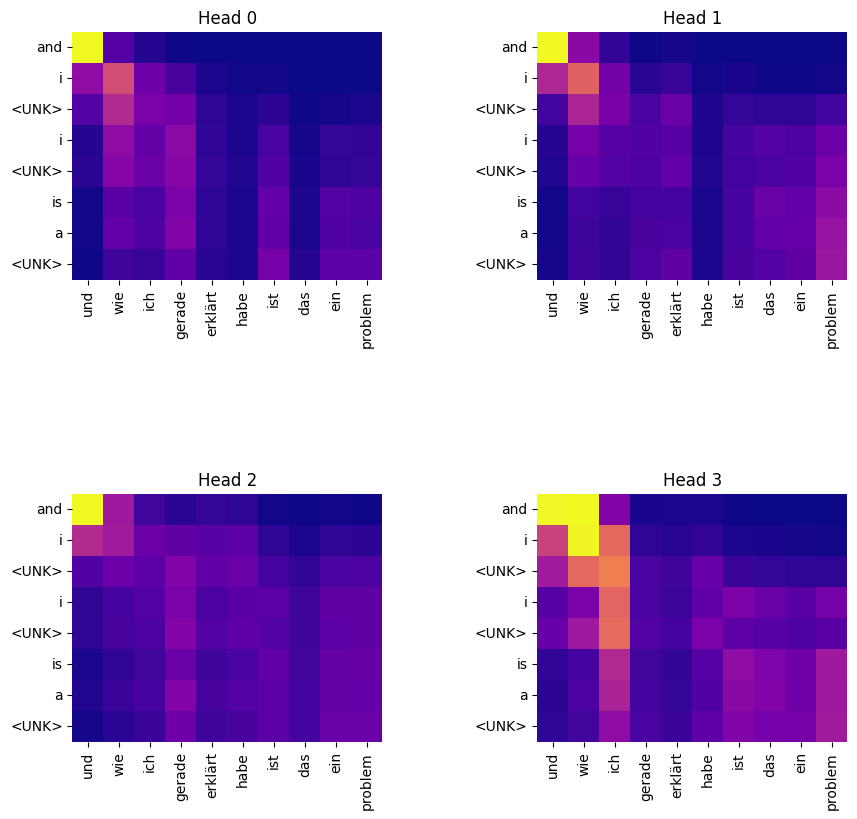

In [47]:
savepath=f'{task_dir}/models/'

model = FullTransformerModel(task.en_vocab_size,
                        task.de_vocab_size).to(device)
model.load_state_dict(torch.load(savepath + '/ckpt.pt', 
                                    map_location=torch.device(device)))


max_len = 20
output = ""
for i in range(max_len):
    # We use  "autoregressive decoding" - At each step, we take the output of 
    # the decoder from the previous step and use it as the input for the decoder 
    # in the next step, i.e. we keep repetatively feeding `output` back. 
    predictions, attention = model(
        torch.Tensor(samples).to(device),
        torch.Tensor(task.embed(output, task.en_dict, sos=True)).to(device))
    
    predictions = predictions.detach().cpu().numpy()
    
    output += " " + task.prettify(predictions[0], task.en_dict).split()[i]
    

print("Input:")
print(regex.sub("\s<PAD>", "", task.prettify(samples[0], task.de_dict)))
print()
print("Truth:")
print(regex.sub("\s<PAD>", "", task.prettify(truth[0], task.en_dict)))
print()
print("Output:")
print(regex.sub("\s<PAD>", "", task.prettify(predictions[0], task.en_dict)))

fig = plt.figure(figsize=(10, 10))
gs = gridspec.GridSpec(2, 2, hspace=0.5, wspace=0.5)
x_labels = regex.sub("\s<PAD>", "", task.prettify(samples[0], task.de_dict)).split()
y_labels = regex.sub("\s<PAD>", "", task.prettify(predictions[0], task.en_dict)).split()
for i in range(4):
    ax = plt.Subplot(fig, gs[i])
    head_attention = attention[i].squeeze(0).detach().numpy()
    seaborn.heatmap(
        data=head_attention[ :len(y_labels), :len(x_labels)],
        xticklabels=x_labels,
        yticklabels=y_labels,
        ax=ax,
        cmap='plasma',
        vmin=np.min(head_attention),
        vmax=np.max(head_attention),
        cbar=False)
    ax.set_title("Head {}".format(i))
    ax.set_aspect('equal')
    for tick in ax.get_xticklabels():
        tick.set_rotation(90)
    for tick in ax.get_yticklabels():
        tick.set_rotation(0)
    fig.add_subplot(ax)
plt.show()